# Stacking

* Training D1_D2 dataset using the `Stacking` ensemble method.
* Grid Search for best parameters

### Author
Ajinkya Indulkar

In [1]:
# import libraries
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings(action='ignore')

# import custom class
from tadpole import Tadpole

# base learners
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# ensemble learning - stacking
from sklearn.ensemble import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

# metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import make_scorer, confusion_matrix

# import visualization library
from matplotlib import pyplot as plt
import seaborn as sns


# set seed (for reproducibility)
np.random.seed(43)

%matplotlib inline
sns.set(style='whitegrid', palette="deep", font_scale=0.7, rc={"figure.figsize": [8, 5]})

### Data Loading + Pre-processing

In [2]:
# initialize class
tp = Tadpole(debug=True)

loading tadpole dataset
pre-processing dataset


In [3]:
# train-test split
X_train, X_test, y_train, y_test = tp.split()

splitting dataset to train and test datasets


In [4]:
# import variables from class instance (notebook compatibility)
X, y, label_dict = tp.X, tp.y, tp.label_dict

In [5]:
# define scoring parameter
scoring = {'BA': make_scorer(balanced_accuracy_score)}

Helper Functions

In [7]:
def showConfusionMatrix(clf, X, y):
    cm = confusion_matrix(y, clf.predict(X))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm, cmap='GnBu')
    ax.grid(False)

    # For 3 categories
    ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted ' + label_dict[0], 'Predicted ' + label_dict[1], 
                                              'Predicted ' + label_dict[2]))
    ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual ' + label_dict[0], 'Actual ' + label_dict[1], 
                                              'Actual ' + label_dict[2]))

    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.title('Test Data Confusion Matrix')
    plt.show()
    
def computeMetrics(model, X, y):
    """
    @description:
        function to compute performance metrics
    @arguments:
        model (sklearn) - trained model
        X (np.array) - features
        y (np.array) - target
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)
    BCA = balanced_accuracy_score(y, y_pred)
    mAUC = roc_auc_score(y, y_prob, multi_class="ovr", average="macro")
    return BCA, mAUC

def report(model):
    """
    @description:
        function to report trained model performance
    @arguments:
        model (sklearn) - trained model
    """
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    BCA_train, mAUC_train = computeMetrics(model, X_train, y_train)
    BCA_test, mAUC_test = computeMetrics(model, X_test, y_test)
    print("========Model Evaluation Report========")
    print("Train Score: ", score_train)
    print("Test Score: ", score_test)
    print("=======================================")
    print("Train BCA: {:.3f} | Train AUC: {:.3f}".format(BCA_train, mAUC_train))
    print("Test BCA: {:.3f} | Test AUC: {:.3f}".format(BCA_test, mAUC_test))
    print("=======================================")
    showConfusionMatrix(model, X_test, y_test)
    return [score_train, score_test, BCA_train, BCA_test, mAUC_train, mAUC_test]

def evaluate(baselearners):
    """
    @description:
        function to evaluate base learners
    @arguments:
        baselearners (sklearn) - list of trained models
    """
    metrics = []
    for name, model in baselearners.items():
        print(name)
        results = report(model)
        metrics.append([name] + results)
    return metrics

### Base Learners: Model Training

#### Logistic Regression (LRA)

The following parameter grids were found to work best for the base learners: 
    
1. **LRA**: {'C': 0.08858667904100823, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}

2. **DT**: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.5, 'splitter': 'best'}

3. **MLP**: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 
'adam'}

4. **SVM**: {'C': 1000, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'linear', 'tol': 1}

In [8]:
# define and train
lra = LogisticRegression(verbose=2)
lra.set_params(**{'C': 0.08858667904100823, 'class_weight': 'balanced', 'dual': False, 
                'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001})
lra.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=0.08858667904100823, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

#### Decision Trees (DT)

In [9]:
# define and train
dtc = DecisionTreeClassifier()
dtc.set_params(**{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 
                  'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.5, 
                  'splitter': 'best'})
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.2, min_samples_split=0.5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### Multi-layer Perceptron (ANN)

In [10]:
# define and train
mlp = MLPClassifier(verbose=True)
mlp.set_params(**{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 
                  'learning_rate': 'adaptive', 'solver': 'adam'})
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.18587792
Iteration 2, loss = 1.05711820
Iteration 3, loss = 0.98842656
Iteration 4, loss = 0.96469965
Iteration 5, loss = 0.93512903
Iteration 6, loss = 0.89640073
Iteration 7, loss = 0.84780304
Iteration 8, loss = 0.79007843
Iteration 9, loss = 0.72733721
Iteration 10, loss = 0.66972971
Iteration 11, loss = 0.61711702
Iteration 12, loss = 0.57736693
Iteration 13, loss = 0.54621083
Iteration 14, loss = 0.51531036
Iteration 15, loss = 0.49036928
Iteration 16, loss = 0.47106084
Iteration 17, loss = 0.45183221
Iteration 18, loss = 0.43934933
Iteration 19, loss = 0.42646212
Iteration 20, loss = 0.41497846
Iteration 21, loss = 0.40753935
Iteration 22, loss = 0.39825757
Iteration 23, loss = 0.39237880
Iteration 24, loss = 0.38498474
Iteration 25, loss = 0.38828775
Iteration 26, loss = 0.37515908
Iteration 27, loss = 0.37344045
Iteration 28, loss = 0.37835774
Iteration 29, loss = 0.39721291
Iteration 30, loss = 0.37091714
Iteration 31, loss = 0.36371571
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

#### SVM

In [11]:
# define and train
svm = SVC(verbose=True, probability=True)
svm.set_params(**{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.001, 
                  'kernel': 'linear', 'tol': 1})
svm.fit(X_train, y_train)

[LibSVM]

SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=1, verbose=True)

#### Evaluate Base Learners

In [12]:
# define dictionary of all baselearners
baselearners = {'LRA': lra, 'DT': dtc, 'ANN': mlp, 'SVM': svm}

LRA
========Model Evaluation Report========
Train Score:  0.875
Test Score:  0.9017341040462428
Train BCA: 0.891 | Train AUC: 0.961
Test BCA: 0.918 | Test AUC: 0.968


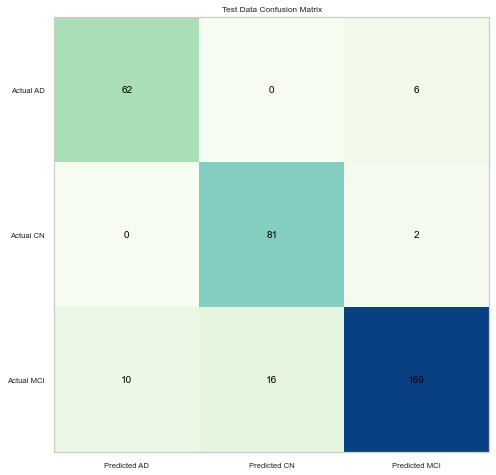

DT
========Model Evaluation Report========
Train Score:  0.7030346820809249
Test Score:  0.7254335260115607
Train BCA: 0.777 | Train AUC: 0.854
Test BCA: 0.788 | Test AUC: 0.868


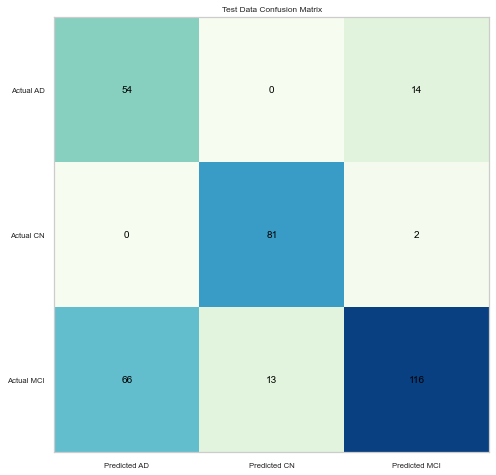

ANN
========Model Evaluation Report========
Train Score:  0.884393063583815
Test Score:  0.9046242774566474
Train BCA: 0.890 | Train AUC: 0.975
Test BCA: 0.909 | Test AUC: 0.975


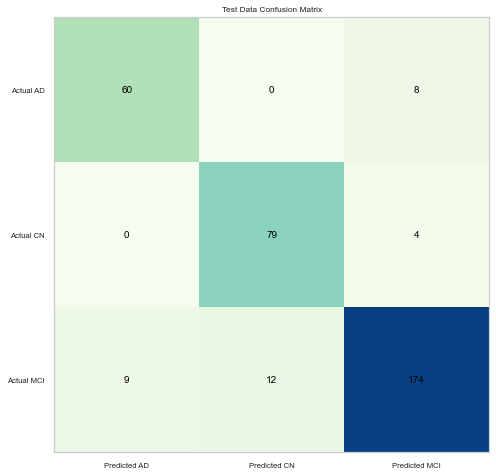

SVM
========Model Evaluation Report========
Train Score:  0.8764450867052023
Test Score:  0.8988439306358381
Train BCA: 0.897 | Train AUC: 0.960
Test BCA: 0.916 | Test AUC: 0.970


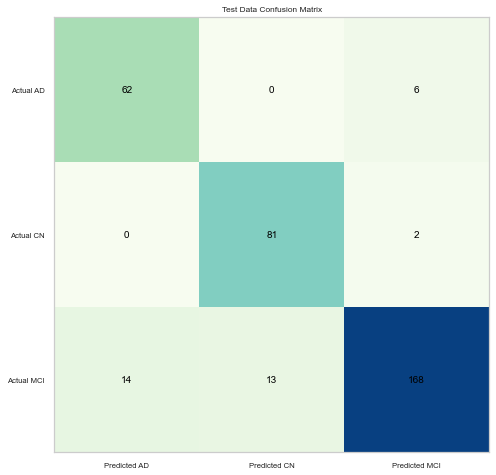

In [13]:
# evaluate
metrics = evaluate(baselearners)

### Stacking - Ensemble Learning: Model Training

Level 1 Classifiers - LRA, DT, ANN and SVM

Level 2 Classifier - LRA

In [14]:
# define level 1 estimators
estimators = [
    ('lra', lra),
    ('dt', dtc),
    ('ann', mlp),
    ('svm', svm)
]

In [15]:
# define and train stacking ensemble method
stk_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), verbose=2)
stk_clf.fit(X_train, y_train)

[LibLinear]Iteration 1, loss = 1.02035177
Iteration 2, loss = 0.97285892
Iteration 3, loss = 0.93489533
Iteration 4, loss = 0.88506949
Iteration 5, loss = 0.82681659
Iteration 6, loss = 0.76660870
Iteration 7, loss = 0.70432572
Iteration 8, loss = 0.65069250
Iteration 9, loss = 0.60553605
Iteration 10, loss = 0.57284180
Iteration 11, loss = 0.54911446
Iteration 12, loss = 0.52912943
Iteration 13, loss = 0.50851471
Iteration 14, loss = 0.49426235
Iteration 15, loss = 0.47693818
Iteration 16, loss = 0.46831455
Iteration 17, loss = 0.45514535
Iteration 18, loss = 0.44783507
Iteration 19, loss = 0.43907598
Iteration 20, loss = 0.43162372
Iteration 21, loss = 0.43008231
Iteration 22, loss = 0.41887670
Iteration 23, loss = 0.41241176
Iteration 24, loss = 0.40617589
Iteration 25, loss = 0.40087529
Iteration 26, loss = 0.39694962
Iteration 27, loss = 0.39068860
Iteration 28, loss = 0.38695082
Iteration 29, loss = 0.38499072
Iteration 30, loss = 0.38023551
Iteration 31, loss = 0.37720460
Iterat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Iteration 1, loss = 1.09365203
Iteration 2, loss = 1.03304154
Iteration 3, loss = 0.99407401
Iteration 4, loss = 0.97352777
Iteration 5, loss = 0.95820637
Iteration 6, loss = 0.93487830
Iteration 7, loss = 0.90868339
Iteration 8, loss = 0.87630632
Iteration 9, loss = 0.83718203
Iteration 10, loss = 0.79356186
Iteration 11, loss = 0.74312379
Iteration 12, loss = 0.69221953
Iteration 13, loss = 0.64570783
Iteration 14, loss = 0.60729174
Iteration 15, loss = 0.57544165
Iteration 16, loss = 0.54947618
Iteration 17, loss = 0.52958442
Iteration 18, loss = 0.50990068
Iteration 19, loss = 0.49753118
Iteration 20, loss = 0.48222515
Iteration 21, loss = 0.47180539
Iteration 22, loss = 0.46207298
Iteration 23, loss = 0.45075212
Iteration 24, loss = 0.44306659
Iteration 25, loss = 0.43362127
Iteration 26, loss = 0.42864325
Iteration 27, loss = 0.41990571
Iteration 28, loss = 0.41722037
Iteration 29, loss = 0.41175793
Iteration 30, loss = 0.404

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


Iteration 8, loss = 0.81640699
Iteration 9, loss = 0.76940830
Iteration 10, loss = 0.72103241
Iteration 11, loss = 0.67373001
Iteration 12, loss = 0.63132736
Iteration 13, loss = 0.59785683
Iteration 14, loss = 0.56556993
Iteration 15, loss = 0.54376868
Iteration 16, loss = 0.52182667
Iteration 17, loss = 0.50035754
Iteration 18, loss = 0.48145727
Iteration 19, loss = 0.46918595
Iteration 20, loss = 0.45917093
Iteration 21, loss = 0.44434528
Iteration 22, loss = 0.43634339
Iteration 23, loss = 0.42387903
Iteration 24, loss = 0.41560657
Iteration 25, loss = 0.41079966
Iteration 26, loss = 0.40086520
Iteration 27, loss = 0.39723611
Iteration 28, loss = 0.39620268
Iteration 29, loss = 0.39097950
Iteration 30, loss = 0.37957633
Iteration 31, loss = 0.37756264
Iteration 32, loss = 0.36772432
Iteration 33, loss = 0.36551920
Iteration 34, loss = 0.36226336
Iteration 35, loss = 0.35946491
Iteration 36, loss = 0.35495325
Iteration 37, loss = 0.35391948
Iteration 38, loss = 0.34910478
Iteration 

Iteration 120, loss = 0.28063308
Iteration 121, loss = 0.28458058
Iteration 122, loss = 0.28461722
Iteration 123, loss = 0.28033056
Iteration 124, loss = 0.28318620
Iteration 125, loss = 0.28305823
Iteration 126, loss = 0.28558729
Iteration 127, loss = 0.27978957
Iteration 128, loss = 0.27692332
Iteration 129, loss = 0.27702635
Iteration 130, loss = 0.27710827
Iteration 131, loss = 0.27798792
Iteration 132, loss = 0.28358930
Iteration 133, loss = 0.28029759
Iteration 134, loss = 0.27489966
Iteration 135, loss = 0.27697536
Iteration 136, loss = 0.27801533
Iteration 137, loss = 0.27480885
Iteration 138, loss = 0.27718235
Iteration 139, loss = 0.28242182
Iteration 140, loss = 0.28416295
Iteration 141, loss = 0.27705450
Iteration 142, loss = 0.29031520
Iteration 143, loss = 0.27776885
Iteration 144, loss = 0.27778172
Iteration 145, loss = 0.27443783
Iteration 146, loss = 0.27901570
Iteration 147, loss = 0.27726278
Iteration 148, loss = 0.27792344
Iteration 149, loss = 0.28342358
Iteration 

Iteration 89, loss = 0.29305640
Iteration 90, loss = 0.29676655
Iteration 91, loss = 0.28977292
Iteration 92, loss = 0.28951787
Iteration 93, loss = 0.28851126
Iteration 94, loss = 0.28982572
Iteration 95, loss = 0.28993578
Iteration 96, loss = 0.28699267
Iteration 97, loss = 0.29416101
Iteration 98, loss = 0.28731637
Iteration 99, loss = 0.28503057
Iteration 100, loss = 0.28903625
Iteration 101, loss = 0.29008316
Iteration 102, loss = 0.29107722
Iteration 103, loss = 0.28955295
Iteration 104, loss = 0.28645382
Iteration 105, loss = 0.28874461
Iteration 106, loss = 0.28439783
Iteration 107, loss = 0.28695858
Iteration 108, loss = 0.28734452
Iteration 109, loss = 0.28641815
Iteration 110, loss = 0.28402481
Iteration 111, loss = 0.28408949
Iteration 112, loss = 0.28299046
Iteration 113, loss = 0.29148031
Iteration 114, loss = 0.28831342
Iteration 115, loss = 0.29001448
Iteration 116, loss = 0.29136120
Iteration 117, loss = 0.28753242
Iteration 118, loss = 0.27927774
Iteration 119, loss =

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[LibSVM][LibSVM][LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


StackingClassifier(cv=None,
                   estimators=[('lra',
                                LogisticRegression(C=0.08858667904100823,
                                                   class_weight='balanced',
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l1',
                                                   random_state=None,
                                                   solver='liblinear',
                                                   tol=0.0001, verbose=2,
                                                   warm_start=False)),
                               ('dt',
                        

========Model Evaluation Report========
Train Score:  0.8807803468208093
Test Score:  0.9161849710982659
Train BCA: 0.887 | Train AUC: 0.968
Test BCA: 0.923 | Test AUC: 0.973


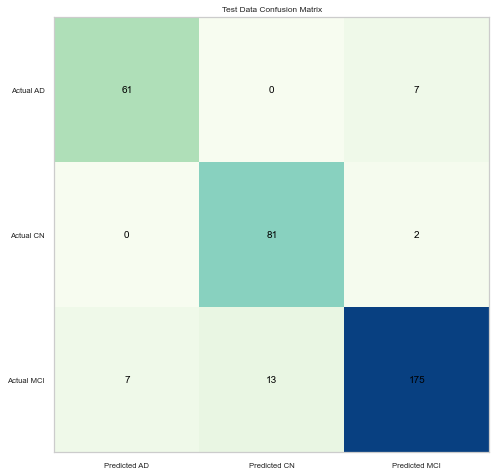

In [16]:
el_metrics = report(stk_clf)

### Save Best Model

In [17]:
model_name = "stacking_070620_1.pkl" #ensemble-date-modelversion

tp.save(stk_clf, model_name)

saving trained model


### Visualize Results

In [18]:
# add stacking results
metrics.append(['stacking'] + el_metrics)
# create results dataframe
results_df = pd.DataFrame(metrics, columns=['classifier', 'score_train', 'score_test', 'BCA_train', 'BCA_test', 
                                            'mAUC_train', 'mAUC_test'])

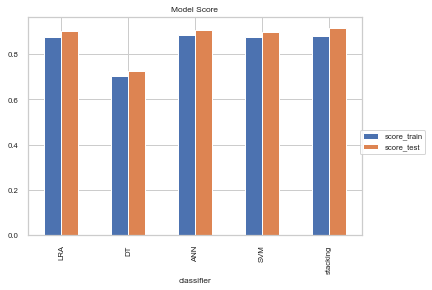

In [19]:
results_df.plot(x='classifier', y=['score_train', 'score_test'], kind='bar', 
                title='Model Score', grid=True).legend(bbox_to_anchor=(1.2, 0.5));

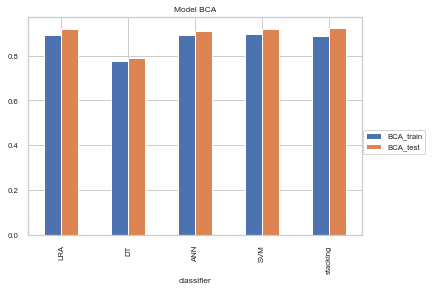

In [20]:
results_df.plot(x='classifier', y=['BCA_train', 'BCA_test'], kind='bar', 
                title='Model BCA', grid=True).legend(bbox_to_anchor=(1.2, 0.5));

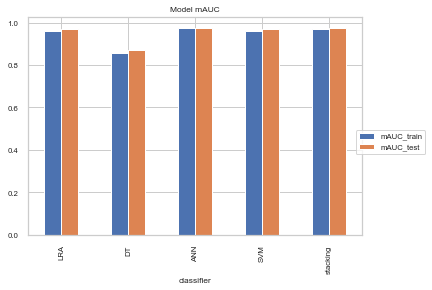

In [21]:
results_df.plot(x='classifier', y=['mAUC_train', 'mAUC_test'], kind='bar', 
                title='Model mAUC', grid=True).legend(bbox_to_anchor=(1.2, 0.5));

### Grid Search: Stacking

In [22]:
clf1 = LogisticRegression(class_weight='balanced')
clf2 = DecisionTreeClassifier(class_weight='balanced')
clf3 = MLPClassifier(learning_rate='adaptive')
clf4 = SVC(probability=True, class_weight='balanced')
lr = LogisticRegression(class_weight='balanced')
    
stk_params = {'logisticregression__C' : np.logspace(-4, 4, 10),
              'decisiontreeclassifier__max_depth' : [7, 8, 9, 10],       
              'mlpclassifier__hidden_layer_sizes' : [(50,50,50), (50,100,50), (100,)],
              'svc__C' : [1, 10, 100, 1000],
              'meta_classifier__C' : np.logspace(-4, 4, 10)}

In [23]:
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], meta_classifier=lr,
                            random_state=43, use_probas=True, verbose=2)
stk_cv = tp.gridsearch(stk_params, sclf, scoring, n_jobs=10)

performing grid search
Fitting 5 folds for each of 4800 candidates, totalling 24000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   24.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  8.2min
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed: 13.1min
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed: 18.7min
[Parallel(n_jobs=10)]: Done 1965 tasks      | elapsed: 25.1min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed: 32.6min
[Parallel(n_jobs=10)]: Done 3261 tasks      | elapsed: 41.8min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 51.4min
[Parallel(n_jobs=10)]: Done 4881 tasks      | elapsed: 61.7min
[Parallel(n_jobs=10)]: Done 5812 tasks      | elapsed: 72.8min
[Parallel(n_jobs=10)]: Done 6825 tasks      | elapsed: 84.5min
[Parallel(n_jobs=10)]: Done 7918 tasks      | elapsed: 97.3min
[Parallel(n_jobs=10)]: Done 9093 tasks      | 

Fitting 4 classifiers...
Fitting classifier1: logisticregression (1/4)
LogisticRegression(C=166.81005372000558, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Fitting classifier2: decisiontreeclassifier (2/4)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Fitting classifier3: mlpclassifier (3/4)
MLPClassifier(activation='relu', alpha=0.0001, batch_size='a

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


Fitting classifier4: svc (4/4)
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [24]:
stk_cv.best_params_

{'decisiontreeclassifier__max_depth': 10,
 'logisticregression__C': 166.81005372000558,
 'meta_classifier__C': 1291.5496650148827,
 'mlpclassifier__hidden_layer_sizes': (50, 50, 50),
 'svc__C': 1000}

========Model Evaluation Report========
Train Score:  0.8966763005780347
Test Score:  0.8959537572254336
Train BCA: 0.921 | Train AUC: 0.987
Test BCA: 0.915 | Test AUC: 0.974


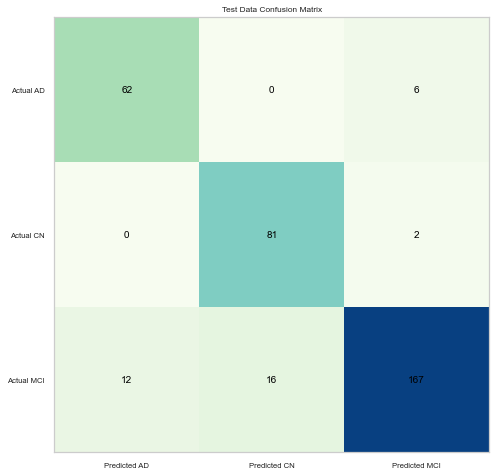

In [25]:
el_cv_metrics = report(stk_cv.best_estimator_)